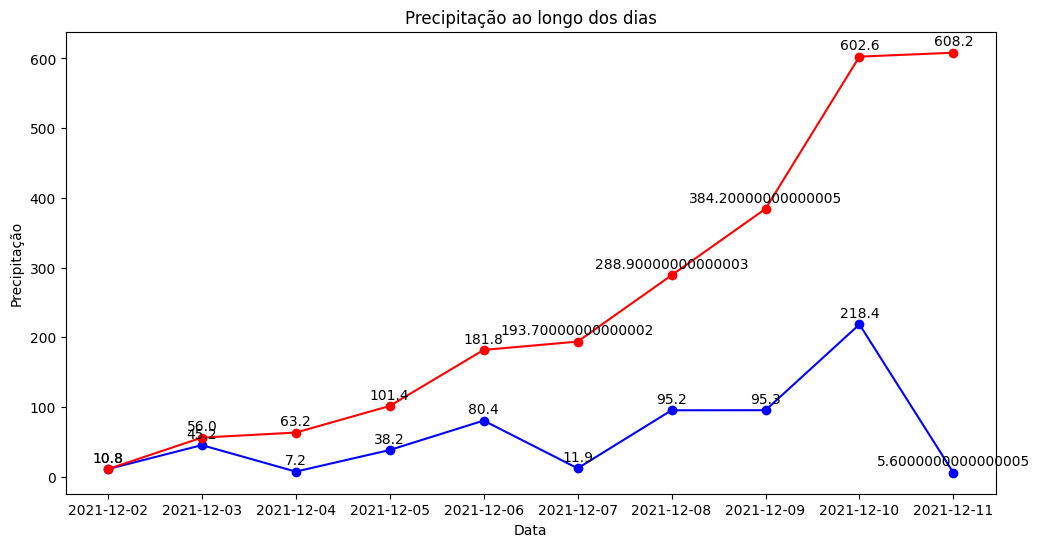

In [10]:
import pandas as pd
import re
import time
from functools import wraps

import geopandas as gpd
from shapely.geometry import Point, Polygon
import os
import re

import matplotlib.pyplot as plt

from pandas.tseries.offsets import DateOffset

def read_data_file(file_path: str) -> pd.DataFrame:
    with open(file_path, "r") as f:
        raw_file = f.readlines()

    list_dados = [line.split() for line in raw_file]
    float_raw_lines = [list(map(float, raw_line)) for raw_line in list_dados]
    return pd.DataFrame(float_raw_lines, columns=["lat", "long", "data_value"])


def read_contour_file(file_path: str) -> pd.DataFrame:
    line_split_comp = re.compile(r"\s*,")

    with open(file_path, "r") as f:
        raw_file = f.readlines()

    l_raw_lines = [
        line_split_comp.split(raw_file_line.strip()) for raw_file_line in raw_file
    ]
    l_raw_lines = list(filter(lambda item: bool(item[0]), l_raw_lines))
    float_raw_lines = [list(map(float, raw_line))[:2] for raw_line in l_raw_lines]
    header_line = float_raw_lines.pop(0)
    assert len(float_raw_lines) == int(header_line[0])
    return pd.DataFrame(float_raw_lines, columns=["lat", "long"])


def apply_contour(contour_df: pd.DataFrame, data_df: pd.DataFrame) -> pd.DataFrame:
    pass


def main() -> None:
    # Importando os arquivos de forecast e consolidando
    forecast_folder = r"C:\Users\Vasconcelos\Desktop\Nova pasta\btg-energy-challenge\btg-energy-challenge\forecast_files"
    dfs = []
    for file in os.listdir(forecast_folder):
        path = os.path.join(forecast_folder, file)
        if os.path.isfile(path):
            match = re.search(r"p(\d+)a(\d+)", file)
            forecast_date = match.group(1)
            forecasted_date = match.group(2)

            df = read_data_file(path)
            df["forecast_date"] = pd.to_datetime(forecast_date, format="%d%m%y")
            df["forecasted_date"] = pd.to_datetime(forecasted_date, format="%d%m%y")
            dfs.append(df)

    df_forecast = pd.concat(dfs, ignore_index=True)

    # Importando arquivo de contorno da região
    contour = read_contour_file(r"C:\Users\Vasconcelos\Desktop\Nova pasta\btg-energy-challenge\btg-energy-challenge\PSATCMG_CAMARGOS.bln")

    # Gerando GeoDataFrame da Região e calculando os pontos contidos
    geometry_regiao = [Point(xy) for xy in zip(contour["long"], contour["lat"])]
    gdf_contour = gpd.GeoDataFrame(contour, geometry=geometry_regiao)

    poligono_territorio = Polygon(gdf_contour[["long", "lat"]].values)

    def is_inside(row):
        ponto = Point(row["long"], row["lat"])
        return ponto.within(poligono_territorio)

    df_forecast["inside"] = df_forecast.apply(is_inside, axis=1)

    # Gerando dataframe final, somando precipitação por data
    df_final = (
        df_forecast[["forecasted_date", "data_value"]]
        .where(df_forecast.inside == True)
        .set_index("forecasted_date")
        .resample("D")  # resample to daily data
        .sum()
        .reset_index()
    )

    df_final["accumulated_value"] = df_final["data_value"].cumsum()

    # Plotando resultados

    plt.figure(figsize=(12, 6))
    plt.plot(
        df_final["forecasted_date"],
        df_final["data_value"],
        marker="o",
        linestyle="-",
        color="b",
    )
    plt.plot(
        df_final["forecasted_date"],
        df_final["accumulated_value"],
        marker="o",
        linestyle="-",
        color="red",
    )

    for i, txt in enumerate(df_final["data_value"]):
        plt.annotate(
            txt,
            (df_final["forecasted_date"][i], df_final["data_value"][i]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )

    for i, txt in enumerate(df_final["accumulated_value"]):
        plt.annotate(
            txt,
            (df_final["forecasted_date"][i], df_final["accumulated_value"][i]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )

    plt.xlabel("Data")
    plt.ylabel("Precipitação")
    plt.title("Precipitação ao longo dos dias")

    plt.show()


if __name__ == "__main__":
    main()
